In [1]:
! pip install version_information

In [2]:
! pip install tqdm

In [3]:
! pip install --upgrade pip

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (10.0.1)


In [4]:
! pip install imblearn

In [5]:
#https://ipyton.org/ipython-docdex/config/extsions/autoreload.html
%reload_ext autoreload
%autoreload 2

#version information
%reload_ext version_information
%version_information Cython, matplotlib, numpy, pandas,  qutip, seaborn, scipy, sklearn, tqdm, version_information,

Software,Version
Python,3.6.4 64bit [GCC 7.2.0]
IPython,6.3.1
OS,Linux 4.9.87 linuxkit aufs x86_64 with debian stretch sid
Cython,0.28.2
matplotlib,2.1.2
numpy,1.13.3
pandas,0.22.0
qutip,The 'qutip' distribution was not found and is required by the application
seaborn,0.8.1
scipy,1.0.1


In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pandas.api.types import CategoricalDtype
import pandas as pd
import seaborn as sns
from six.moves import range
from tqdm import tqdm

#import modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, auc,precision_recall_curve,classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#imports for preparing data for sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder


#some packages for cleaning and wrangling
from collections import defaultdict
import datetime as dt
import re



In [7]:
#read in json to pandas dataframe
df_engagement = pd.read_csv('takehome_user_engagement.csv')
df_engagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
#read in json to pandas dataframe
df_users = pd.read_csv('takehome_users.csv', encoding='latin1', infer_datetime_format=True)
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [11]:
df_users.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool

In [12]:
#convert creation time to datetime 
df_users.creation_time = pd.to_datetime(df_users.creation_time)

We notice that last session creation time has some missing values. We could disregard these, but we would be losing information in other columns that will be useful. We instead will replace with zero in order to convert from float to datetime. This will create a nonsensical date which should be easily identifiable.

In [13]:
#fill in missing values
df_users.last_session_creation_time = df_users.last_session_creation_time.fillna(0)
#note 1970 01 01 is a stand in date for missing values.

In [14]:
#convert last session login to datetime utc and then to string
df_users.last_session_creation_time = [dt.datetime.utcfromtimestamp(i) for i in df_users.last_session_creation_time]

# Note: 1970-01-01 will represent missing data for signup .

In [15]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


## Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [16]:
df_engagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [17]:
#check for missing data
df_engagement.isna().any()

time_stamp    False
user_id       False
visited       False
dtype: bool

In [18]:
df_engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [19]:
#count user visits
user_id_visits = df_engagement.groupby('user_id').count()
user_id_visits.head()

,time_stamp,visited
user_id,,
1,1,1
2,14,14
3,1,1
4,1,1
5,1,1


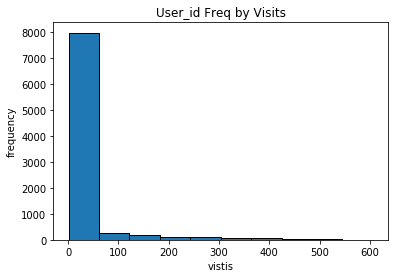

In [20]:
#plot user visits
plt.hist(user_id_visits.visited, edgecolor='k')
plt.xlabel('vistis')
plt.ylabel('frequency')
plt.title('User_id Freq by Visits')
plt.show()
sns.set()#set style

In [21]:
user_id_visits.visited.describe()

count    8823.000000
mean       23.565341
std        73.988152
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       606.000000
Name: visited, dtype: float64

In [22]:
#convert time_stamp column from object to datetime object
df_engagement.time_stamp= pd.to_datetime(df_engagement.time_stamp)

Check if any dates are duplicated. Only worried about logins on the same day, so we will convert the datetime to string date and remove duplicates and/or user_id logged in multiple times one one day. 

In [23]:
#convert last session login to datetime utc and then to string 
df_engagement['date'] = [i.strftime('%Y-%m-%d') for i in df_engagement.time_stamp]

In [24]:
gp_date_duplicates_check = df_engagement.groupby('user_id').apply(lambda x : x.duplicated(subset='date').any())

In [25]:
gp_date_duplicates_check.any() 

False

No one logged in multiple times during one day, and there are no duplicates date entries per user_id. Next we will find adopted users by checking for more than 3 logins per a 7 day window. 

In [26]:
df_engagement  = df_engagement.set_index('time_stamp')

In [27]:
df_engagement.head()

,user_id,visited,date
time_stamp,,,
2014-04-22 03:53:30,1,1,2014-04-22
2013-11-15 03:45:04,2,1,2013-11-15
2013-11-29 03:45:04,2,1,2013-11-29
2013-12-09 03:45:04,2,1,2013-12-09
2013-12-25 03:45:04,2,1,2013-12-25


In [28]:
gp_7d_count = df_engagement.groupby('user_id').rolling('7d',1).count()
gp_7d_count.head()

user_id  visited        date
user_id time_stamp                                       
1       2014-04-22 03:53:30      1.0      1.0  2014-04-22
2       2013-11-15 03:45:04      1.0      1.0  2013-11-15
        2013-11-29 03:45:04      1.0      1.0  2013-11-29
        2013-12-09 03:45:04      1.0      1.0  2013-12-09
        2013-12-25 03:45:04      1.0      1.0  2013-12-25

In [29]:
gp_7d_window_3 = gp_7d_count[gp_7d_count['visited']>=3]
gp_7d_window_3.head()

user_id  visited        date
user_id time_stamp                                       
2       2014-02-09 03:45:04      3.0      3.0  2014-02-09
        2014-02-13 03:45:04      3.0      3.0  2014-02-13
10      2013-02-19 22:08:03      3.0      3.0  2013-02-19
        2013-03-02 22:08:03      3.0      3.0  2013-03-02
        2013-03-05 22:08:03      3.0      3.0  2013-03-05

In [ ]:
#find all users active with 7 day window
week_window=[]
for i in tqdm ( range( len( gp_7d_window_3) ) ):
    if gp_7d_window_3.iloc[i].name[0] not in week_window:
        week_window.append(gp_7d_window_3.iloc[i].name[0])

 47%|████▋     | 75642/160522 [00:11<00:12, 6828.44it/s]

In [ ]:
#check list
week_window[:10]

In [ ]:
df_engagement = df_engagement.reset_index()

# Target Label Assignment

In [ ]:
# assign label for adopted users
for i in week_window:
    df_engagement.loc[i,'adopted']=1

In [ ]:
#fill zero for non-adopted users
df_engagement['adopted'].fillna(0, inplace=True)

In [ ]:
df_engagement.head()

In [ ]:
#calculate percent of engagement from adopted users
(df_engagement.adopted.sum()/df_engagement.adopted.count())*100

In [ ]:
#assign user dataframe labels for adopted users
for i in week_window:
    df_users.loc[i,'adopted']=1

In [ ]:
#fill non-adopted users with zeto
df_users['adopted'].fillna(0, inplace=True)

In [ ]:
df_users = df_users.set_index('object_id')

In [ ]:
df_users.head()

In [ ]:
df_users.adopted.value_counts()

In [ ]:
df_users.adopted.describe()

The postive class is extremely small. We will need to address this in modeling and metric evaluation. 

# EDA

There are not to many features so we will look at each.

In [ ]:

bar_y = [(df_users.adopted.count()-df_users.adopted.sum()),df_users.adopted.sum()]
bar_x = [0,1]
plt.bar(bar_x, bar_y)
x_labels=['Non-Adopted Users','Adopted Users']
plt.xticks(bar_x, x_labels)

#plt.xticks(x_labels,rotation=45)
#plt.xticks('O/Non-Adopted and 1/Adopted')
plt.ylabel('Counts')
plt.title('User Adoption')

plt.savefig('adopted.png')
plt.show()

In [ ]:
#looking at first datetime feature
df_users_signup= df_users[['creation_time','adopted']]

In [ ]:
#a function break out time information to columns
def make_columns( df, column ):
    """news_df is pandas dataframe from csv for twitter account
    tweet_from is name of twitter accout
    ml_df is the dataframe for doing machine learning in a tidy format"""

    df['yr'] = [r.year for r in df[column] ]
    df['moy'] = [r.strftime('%b') for r in df[column] ]
    df['dow'] = [r.strftime('%a') for r in df[column] ] #zero is Monday
    df['hod'] = [r.hour for r in df[column] ]
    df['moh'] = [r.minute for r in df[column] ]
    df['day'] = [r.day for r in df[column] ]
    df['woy'] = [r.weekofyear for r in df[column] ] #starts at 1 not zero
    df['week'] = [r.week for r in df[column] ]
    df['doy'] = [r.dayofyear for r in df[column] ] #starts at 1 not zero
    

In [ ]:
#call function to extract time information to plot
make_columns(df_users_signup,'creation_time' )
df_users_signup.head()

In [ ]:
#change data to cat for plotting
#want days and month in order
#set label names
days = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
months = [ 'Jan', 'Feb', 'Mar', 'Apr','May',"Jun",'Jul','Aug','Sept','Oct','Nov','Dec'] #,'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

#get days in order for 
cat_type = CategoricalDtype(categories=days, ordered=True) #convert to categories to sort
df_users_signup['dow'] = df_users_signup['dow'].astype(cat_type) #relabel values in column

#get months in order (same as above)
cat_type = CategoricalDtype(categories=months, ordered=True)
df_users_signup['moy'] = df_users_signup['moy'].astype(cat_type)



In [ ]:
#group by day of year and adoption of year counts
gp_yr_m = df_users_signup.groupby(  ["yr",'adopted'] ).count()
#check
gp_yr_m.head()

In [ ]:
my_colors= ['#90A743','#6FDA86']

#plot year with stacked month break out
gp_yr_m.creation_time.unstack().plot(kind='bar', stacked=False)
plt.title("Year Trend")
plt.ylabel("Count")
plt.xlabel('Year')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1,title='Adopted Users')
plt.savefig('gp_yr_trend_signup.png')
plt.show()

In [ ]:
#group by day of year, month, and day of week
moy_gp = df_users_signup.groupby(  ['yr',"moy", 'dow'] ).count()
#check
moy_gp.head()

In [ ]:
day_colors= ['#8c510a','#d8b365','#dfc27d','#f6e8c3','#c7eae5','#5ab4ac', '#01665e']

#plot day of week with stacked month year break out
moy_gp.creation_time.unstack().plot(kind='bar', stacked=True, color=day_colors)
plt.title("Month of Year Trend")
plt.ylabel("count of logins")
plt.xlabel('Month')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1, title='Adopted Users')

sns.set()#set style
plt.savefig('mow_trend_signup.png')
plt.show()

In [ ]:
#group by day of year, month, and adoption
gp_yr_moy = df_users_signup.groupby(  ['yr',"moy",'adopted'] ).count()
#check
gp_yr_moy.head()

In [ ]:
day_colors= ['#8c510a','#d8b365','#dfc27d','#f6e8c3','#c7eae5','#5ab4ac', '#01665e']

#plot adoption stacked month year break out
gp_yr_moy.creation_time.unstack().plot(kind='bar', stacked=True, color=day_colors)
plt.title("Month of Year Trend")
plt.ylabel("count of logins")
plt.xlabel('Month')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1, title='Adopted Users')

plt.savefig('yr_m_adopted_trend_signup.png')
plt.show()

We see some data issues here. We should look deeper into what is going on in September. Is there a collection issue? Was the system down? etc. We should also look into the spike in may 2014. Is it real? Is there a bug?

For now we will move onto other features.


In [ ]:
#group by source and adaption
gp_adopted= df_users.groupby(  ['creation_source','adopted'] ).count()

In [ ]:

#plot day of week with stacked month break out
gp_adopted.creation_time.unstack().plot(kind='bar', stacked=False)
plt.title("Creation Source")
plt.ylabel("Count of Creations")
plt.xlabel('Type')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1,title='Adapted Users')

plt.show()

Next feature

In [ ]:
#move time and target to separte dataframe to pull out date information
df_last_session= df_users[['last_session_creation_time','adopted']]

In [ ]:
#break out time data to columns
make_columns(df_last_session,'last_session_creation_time' )
df_last_session.head()

In [ ]:
#change data to cat for plotting
#want days and month in order
#set label names
days = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
months = [ 'Jan', 'Feb', 'Mar', 'Apr','May',"Jun",'Jul','Aug','Sept','Oct','Nov','Dec'] #,'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

#get days in order for 
cat_type = CategoricalDtype(categories=days, ordered=True) #convert to categories to sort
df_last_session['dow'] = df_last_session['dow'].astype(cat_type) #relabel values in column

#get months in order (same as above)
cat_type = CategoricalDtype(categories=months, ordered=True)
df_last_session['moy'] = df_last_session['moy'].astype(cat_type)





In [ ]:
#group by day of year and adoption
gp_yr_m_last_login = df_last_session.groupby(  ["yr", 'adopted'] ).count()
#check
gp_yr_m_last_login.head()

In [ ]:
#plot year trend with adoption bars
gp_yr_m_last_login.last_session_creation_time.unstack().plot(kind='bar', stacked=False)
plt.title("Year Trend")
plt.ylabel("Count")
plt.xlabel('Year')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1.),
          fancybox=True, shadow=True, ncol=1,title='Adopted Users')
sns.set() #set style and save
plt.savefig('gp_yr_trend_last_session.png')
plt.show()

### Recall previous note: 1970 is the unavailable login information

In [ ]:
#group by day of year month and day of week
moy_gp_last_login = df_last_session.groupby(  ['yr',"moy", 'dow'] ).count()
#check
moy_gp_last_login.head()

In [ ]:
day_colors= ['#8c510a','#d8b365','#dfc27d','#f6e8c3','#c7eae5','#5ab4ac', '#01665e']

#plot day of week with stacked month break out
moy_gp_last_login.last_session_creation_time.unstack().plot(kind='bar', stacked=True, color=day_colors)
plt.title("Month of Year Trend")
plt.ylabel("count of logins")
plt.xlabel('Month')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1, title='Day of Week')

sns.set()#set style

plt.show()

Removing the 1970 (unavailable login information)

In [ ]:
day_colors= ['#8c510a','#d8b365','#dfc27d','#f6e8c3','#c7eae5','#5ab4ac', '#01665e']

#plot day of week with stacked month yeat break out
moy_gp_last_login[moy_gp_last_login['last_session_creation_time']<1970].last_session_creation_time.unstack().plot(kind='bar', stacked=True, color=day_colors)
plt.title("Month of Year Trend")
plt.ylabel("count of logins")
plt.xlabel('Month')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1, title='Day of Week')

sns.set()#set style
plt.savefig('mow_trend_last_session.png')
plt.show()

In [ ]:
#group by year month and adoption
gp_yr_moy_last = df_last_session.groupby(  ['yr',"moy",'adopted'] ).count()
#check
gp_yr_moy_last.head()

In [ ]:
day_colors= ['#8c510a','#d8b365','#dfc27d','#f6e8c3','#c7eae5','#5ab4ac', '#01665e']

#plot stacked adoption with year month break out
gp_yr_moy_last[gp_yr_moy_last['last_session_creation_time']<1970].last_session_creation_time.unstack().plot(kind='bar', stacked=True, color=day_colors)
plt.title("Month of Year Trend")
plt.ylabel("count of logins")
plt.xlabel('Month')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1, title='Adopted Users')

sns.set()#set style
plt.savefig('mow_trend_last_session_adopted.png')
plt.show()

In [ ]:
gp_adopted

In [ ]:
#group by source and adaption
gp_adopted= df_users.groupby(  ['opted_in_to_mailing_list','adopted'] ).count()
#plot day of week with stacked month break out
gp_adopted.creation_time.unstack().plot(kind='bar', stacked=False)
plt.title("opted_in_to_mailing_list")
plt.ylabel("counts")
plt.xlabel('0/no and 1/yes')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1,title='Adapted Users')
sns.set() #set style and save
plt.savefig('mailing_list')
plt.show()

In [ ]:
#group by source and adaption
gp_drip= df_users.groupby(  ['enabled_for_marketing_drip','adopted'] ).count()
#plot day of week with stacked month break out
gp_drip.creation_time.unstack().plot(kind='bar', stacked=False)
plt.title("enabled_for_marketing_drip")
plt.ylabel("counts")
plt.xlabel('0/no and 1/yes')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1),
          fancybox=True, shadow=True, ncol=1,title='Adapted Users')
sns.set() #set style and save
plt.savefig('marketing_drip')

In [ ]:
plt.hist(df_users.org_id, bins=100 , edgecolor='k')
plt.xticks(rotation=45)
plt.xlabel('org_id')
plt.ylabel('frequency')
plt.title('the organization (group of users) they belong to')
plt.show()
plt.savefig('org_id.png')

The next feature has missing values which we need to deal with. There is no user_id zero. We will use this as a place holder for missing values in reference to this column.

# Note: zero in 'invited_by_user_id' represents user_ids missing values. 

We can assume that this means that the user joined without being invited by someone. However, this could be a collection issue, or a bug. 

In [ ]:
#fill nan with zero
df_users.invited_by_user_id.fillna(0,inplace=True)

In [ ]:
inviter= df_users[df_users.invited_by_user_id != 0]

In [ ]:
plt.hist(inviter.invited_by_user_id,bins=100, edgecolor='k')
#plt.xticks(rotation=45)
plt.xlabel('user_id')
plt.ylabel('Count of Users invited')
plt.title('User_ids who invite others ')
plt.show()
plt.savefig('invited_by_user_id.png')

EDA comments:

14% of users have adopted. This represents a small positive class. We will need to deal with this before modeling. 

# Preprocessing for modeling
We will one hot encode some of the categorical columns for features.

In [ ]:
#one hot encode for modeling 
df_model = df_users.join(pd.get_dummies(df_users.creation_source))
df_model.head()

In [ ]:
#drop non-essential columns (privacy issues here-do not keep for modeling)
df_model = df_model.drop(columns=["name","email"])

In [ ]:
#create list of features for machine learning
features = list(df_model.columns)

In [ ]:
features

In [ ]:
#drop columns not for feature training
features.remove('creation_time')
features.remove('creation_source')
features.remove('last_session_creation_time')
features.remove('org_id')
features.remove('invited_by_user_id')
features.remove('adopted')
#features.remove('period')

In [ ]:
features

In [ ]:
#separate features from training data
x_df = df_model[features]
x_df.head()

In [ ]:
#capture labels
y_df=df_model['adopted']
y_df.head(3)

In [ ]:
# split into training and test sets
x_train, x_test, y_train, y_test= train_test_split(x_df,y_df, test_size=.3, random_state=42)

In [ ]:
#see if the training data has the proper balance of riders 
print ('% adopted users in training set {:2f}'.format(float(y_train.sum())/y_train.size))
print ('% adopted users in test set {:2f}'.format(float(y_test.sum())/y_test.size))

# Model Selection
We picked a Random Forest and a Gradient Boosting model, both do well with imbalanced data and provide easy interpretability. Interpretability is key since we want to be able to understand the factors that predict future user adoption.

# Model Evaluation
The business problem is to predict which users will adopt. We therefore care more about the postive class of our labels. In model evaluation we will look at the confusion matrix and give special attention to recall as the performance metric to evaluate. 

The confusion matrix is a table of predicted labels and true labels. This will give us a picture of where are model is making tradeoff between the class labels, since we care mostly about positive labels this will be important. 

The recall score is a measure of how many relevant items are selected, that is how many positives are caught. ( True Pos / the sum of True Pos and True Neg ) Also called Sensitivity. 


In [ ]:
#create classifier 
clf_xg = GradientBoostingClassifier(random_state=42)
#fit classifier 
clf_xg.fit(x_train , y_train)

#get the prediction set 
preds_train_xg = clf_xg.predict(x_train)

#make some predictions
preds_xg = clf_xg.predict(x_test)


#print the accuracy score for the training data
training_accuracy_xg = clf_xg.score( x_train , y_train )
print("Accuracy on training data: {:0.2f}".format( training_accuracy_xg ) )

#print the accuracy score for the test data
test_accuracy_xg = clf_xg.score(x_test , y_test)
print("Accuracy on test data: {:0.2f}".format( test_accuracy_xg ) )

#print training f1 score
rscore_train_xg = metrics.recall_score( y_train , preds_train_xg )
print("Recall Score on train data: {:0.4f}".format(rscore_train_xg))

#print testing f1 score
rscore_xg = metrics.recall_score( y_test , preds_xg, pos_label=1 )
print("Recall Score on validation (test set) data: {:0.4f}\n".format( rscore_xg ) )


print ( classification_report ( y_test , preds_xg ))

In [ ]:
mat_xg = confusion_matrix( y_test , preds_xg )
sns.heatmap(mat_xg.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title("Boost Model Imbalanced")
plt.show()


We see that the model is severely impacted by the imbalanced data. The model does not predict any adopted users. The accuracy score is miss leading at 87%. The business need of predicting adopted users is completely lost here.

# Addressing the imbalance issue

We will considered resampling. Resampling a method by repeated sampling within in desired under represented class.Two techniques basic techniques (there are many advanced options).

1. Over-sampling - adding samples from the minority class (positives here). Adding samples (duplicates) from the minority class can led to overfitting.

2. Under-sampling - removing samples from the majority class (negatives here). Removing samples from the majority class is information lost and can led to degraded performance.

3. SMOTE is a more advanced technique (which was used here)

SMOTE ( Synthetic Minority Oversampling Technique) uses a k-nearest neighbor model to create new instances of the minority class. It does this by looping through the class and for each loop creating a new data point (instance) of the minority class between a randomly selected k and its nearest neighbor.

In [ ]:
#resample using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42 , ratio= 1.0)
x_train , y_train = sm.fit_sample(x_train, y_train)

In [ ]:
#see if the training data has the proper balance of riders 
print ('% adopted users in training set {:2f}'.format(float(y_train.sum())/y_train.size))



The training set is now balanced.

In [ ]:
#create classifier
clf_xg = GradientBoostingClassifier(random_state=42)
#fit classifier 
clf_xg.fit(x_train , y_train)

#get the prediction set 
preds_train_xg = clf_xg.predict(x_train)

#make some predictions
preds_xg = clf_xg.predict(x_test)


#print the accuracy score for the training data
training_accuracy_xg = clf_xg.score( x_train , y_train )
print("Accuracy on training data: {:0.2f}".format( training_accuracy_xg ) )

#print the accuracy score for the test data
test_accuracy_xg = clf_xg.score(x_test , y_test)
print("Accuracy on test data: {:0.2f}".format( test_accuracy_xg ) )

#print training f1 score
rscore_train_xg = metrics.recall_score( y_train , preds_train_xg )
print("Recall Score on train data: {:0.4f}".format(rscore_train_xg))

#print testing f1 score
rscore_xg = metrics.recall_score( y_test , preds_xg, pos_label=1 )
print("Recall Score on validation (test set) data: {:0.4f}\n".format( rscore_xg ) )


print ( classification_report ( y_test , preds_xg ))

In [ ]:
mat_xg = confusion_matrix( y_test , preds_xg )
sns.heatmap(mat_xg.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title("Boost Model Balanced")
plt.show()

Notice the marked improvement. We are now actually predicting for the positive class. Before we had zero predicted positive labels so we missed all 454 adopted users. Here we predicted 178 adopted users correctly out of 454 an improvement of 39%. We see this in the recall score. 

# Lets try a Random Forest

In [ ]:
#create classifier 
clf_rf=RandomForestClassifier(random_state=42)
#fit classifier to training set
clf_rf.fit(x_train , y_train)

#get the prediction set 
preds_train_rf = clf_rf.predict(x_train)

#make some predictions
preds_rf = clf_rf.predict(x_test)


#print the accuracy score for the training data
training_accuracy_rf = clf_rf.score( x_train , y_train )
print("Accuracy on training data: {:0.2f}".format( training_accuracy_rf ) )

#print the accuracy score for the test data
test_accuracy_rf = clf_rf.score(x_test , y_test)
print("Accuracy on test data: {:0.2f}".format( test_accuracy_rf ) )

#print training f1 score
rscore_train_rf = metrics.recall_score( y_train , preds_train_rf )
print("Recall Score on train data: {:0.4f}".format(rscore_train_rf))

#print testing f1 score
rscore_rf = metrics.recall_score( y_test , preds_rf , pos_label=1 )
print("Recall Score on validation (train-test set) data: {:0.4f}\n".format( rscore_rf ) )


print ( classification_report ( y_test , preds_rf ))

In [ ]:
mat_rf = confusion_matrix( y_test , preds_rf )
sns.heatmap(mat_rf.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Random Forest Balanced')
plt.show()

The Boost Model is slightly better by 178 compared to 174 predicted true labels. The recall scores are 39% to 38% in favor of boosting. 


In [ ]:
#dictionary to hold scores from models
plot_model={ "Boost" :rscore_xg,'RF':rscore_rf }

#make an instance for plotting figures
fig, ax = plt.subplots()

#set parameters for bar chart
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

#plot bar for chart
rects1 = ax.bar(ind, plot_model.values(), color= ['sandybrown','peachpuff','khaki'])

#define a function to add bar chart labels to bars (straight from matplotlib docs)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*float(height),'%.4f' % float(height),ha='center', va='bottom')
        
#call function to add bar char labels to bars
autolabel(rects1)


# add some text for axes ticks
ax.set_xticks(ind)
ax.set_xticklabels(plot_model.keys())

ax.legend()

#add label and title
plt.title("Comparison of the different models",y = 1.08)
plt.xlabel("Models")
plt.ylabel("Recall Score")
#save figure for papers
plt.tight_layout()
plt.savefig('models_rscore.png')
#show figure in notebook
plt.show()





The Boosted Tree Model did slightly better. Lets work with that model to see if we can improve it the recall score by tuning for it. 

In [ ]:
#know lets tune the parameters for the Gradient Booster

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters_xg={'n_estimators':range(50,100) ,"learning_rate" :[.05, .1, .2], 'max_depth':range(1,10)}

#create an instance of the classifier
xg = GradientBoostingClassifier(random_state=42)

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs_xg = RandomizedSearchCV(xg, param_distributions=parameters_xg,cv=5,refit=True,n_jobs=2,random_state=42,scoring='recall')

#fit grid search on random forest over grid
%time rs_xg.fit( x_train ,  y_train )

In [ ]:
rs_xg.best_params_

In [ ]:
rs_xg.best_estimator_

In [ ]:
#create classifier from best parameters out of grid search
clf_xg = rs_xg.best_estimator_
#fit classifier to validation set
clf_xg.fit(x_train , y_train)

#get the prediction set for the validation 
preds_train_xg = clf_xg.predict(x_train)

#make some predictions
preds_xg = clf_xg.predict(x_test)


#print the accuracy score for the training data
training_accuracy_xg = clf_xg.score( x_train , y_train )
print("Accuracy on training data: {:0.2f}".format( training_accuracy_xg ) )

#print the accuracy score for the test data
test_accuracy_xg = clf_xg.score(x_test , y_test)
print("Accuracy on test data: {:0.2f}".format( test_accuracy_xg ) )

#print training f1 score
rscore_train_xg = metrics.recall_score( y_train , preds_train_xg )
print("Recall Score on train data: {:0.4f}".format(rscore_train_xg))

#print testing f1 score
rscore_xg = metrics.recall_score( y_test , preds_xg , pos_label=1 )
print("Recall Score on validation (train-test set) data: {:0.4f}\n".format( rscore_xg ) )


print ( classification_report ( y_test , preds_xg ))

In [ ]:
mat_xg = confusion_matrix( y_test , preds_xg )
sns.heatmap(mat_xg.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Random Forest Balanced')
plt.show()

Here we see an increase in the predicted true labels up 67 (to 245 from 178 untuned) but we lose predicted true negatives by 478 (from 1997 to 1519). The recall score highlights the gain in predicting adopted users (positive labels) with score of .54. The accuracy score has moved down highlighting the loss of true negative predictions. This is where the business needs should give guidance. If we solely care about predicting users who will adopt (predicted true and is true) then the tuned model for recall will be better. The previous model (not tuning for recall) would be better if we care about predicting for users who don't adopt.

This highlights how we can adjust the model to target which prediction (group) we care more about. 

Finally we will look at the features the model used in making its decision.

In [ ]:
#Capture model feature importance 
importances_xg =clf_xg.feature_importances_
sorted_features_xg = sorted (zip (features,importances_xg), key =lambda x:x[1]*-1)

#get length of x axis 
x_values = list(range(len(sorted_features_xg[:10])))
#plot feature importance 
for i in range(len(sorted_features_xg[:10])):
    plt.bar( x_values, [pt[1] for pt in sorted_features_xg[:10]], color='skyblue')
    plt.xticks(x_values, [pt[0] for pt in sorted_features_xg[:10]],label = 'id %s'%i, rotation='vertical', fontsize=10)
    
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Boosting Top Feature Importances');

plt.tight_layout()
#save figure
plt.savefig('feature_importance_10.png')
#show figure in notebook
plt.show()

We see that ‘Personal_Projects,’ ‘Enabled_Marketing_Drip’ and ‘Original_Invite’ are leading features that our model used. This information is valuable and gives insight into what could draw more adopted users. We see ‘Org_Invite’ and ‘Personal_Projects’ are two good candidates. A marketing push highlighting the “personal projects” could draw new users who would be more likely be adopted users. We can also look for ways to transition Guest_Invites accounts to ones with full access. 